<a href="https://colab.research.google.com/github/ankita9084/Pytorch-Lightning/blob/main/Transfer_Learning_using_Resnet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install pytorch-lightning
!pip install pytorch-lightning-bolts

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pytorch_lightning as pl

In [4]:
print(f"pl version: {pl.__version__}")

pl version: 1.6.3


In [5]:
!pip install lightning-bolts

     |████████████████████████████████| 316 kB 5.0 MB/s 


In [6]:
import pl_bolts

In [7]:
from torchvision.models.resnet import resnet152
import torch
from torchvision import models

resnet152 = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [8]:
from torchvision import transforms
from torchmetrics import Accuracy

In [9]:
train_transformer=transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
    )
])


test_transformer=transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
    )
])

In [10]:
train='/content/drive/MyDrive/Programs/Datasets/Leukemia/Train'
test='/content/drive/MyDrive/Programs/Datasets/Leukemia/Test'

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
train_loader=DataLoader(torchvision.datasets.ImageFolder(
    train, transform=train_transformer), 
    batch_size=256,
    shuffle=True)

test_loader=DataLoader(torchvision.datasets.ImageFolder(
    test, transform=test_transformer),
    batch_size=256,
    shuffle=True)

In [12]:
for batch in train_loader:
    x, y = batch
    print(x.shape, y.shape)
    break

torch.Size([256, 3, 224, 224]) torch.Size([256])


In [13]:
batch_size=256

In [14]:
for batch in test_loader:
    x, y = batch
    print(x.shape, y.shape)
    break

torch.Size([104, 3, 224, 224]) torch.Size([104])


In [15]:

import torch
from torchvision import models

resnet152 = models.resnet152(pretrained=True)

for param in resnet152.parameters():
    param.requires_grad = False

num_classes = 3
resnet152.fc = torch.nn.Linear(resnet152.fc.in_features, num_classes)

In [17]:
x, y = next(iter(train_loader))

preds = resnet152(x)
preds[:5]

tensor([[-0.1290, -0.0172,  0.1536],
        [ 0.0567, -0.0156,  0.3331],
        [ 0.0033,  0.6698,  0.1733],
        [ 0.0467,  0.1691,  0.1206],
        [ 0.1147,  0.1604,  0.0486]], grad_fn=<SliceBackward0>)

In [18]:
from torch.nn.functional import softmax

preds = softmax(preds, dim=-1)
preds[:5]

tensor([[0.2903, 0.3246, 0.3851],
        [0.3078, 0.2863, 0.4058],
        [0.2420, 0.4712, 0.2868],
        [0.3118, 0.3524, 0.3357],
        [0.3353, 0.3509, 0.3138]], grad_fn=<SliceBackward0>)

In [19]:
pred_labels = torch.argmax(preds, dim=-1)
pred_labels[:5]

tensor([2, 2, 1, 1, 1])

In [20]:
class LitDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.prepare_data_per_node = True

In [21]:

class LITDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=256):
        self.batch_size=batch_size
        self.prepare_data_per_node = False

    def prepare_data(self):
        
        train='/content/drive/MyDrive/Programs/Datasets/Leukemia/Train'
        test='/content/drive/MyDrive/Programs/Datasets/Leukemia/Test'

    def setup(self, stage= None):
      if stage == "fit" or stage is None:
        train_transformer=transforms.Compose([
                                              transforms.Resize(256),
                                              transforms.RandomCrop(224),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

      if stage == "test" or stage is None:  

        test_transformer=transforms.Compose([
                                              transforms.Resize(256),
                                              transforms.RandomCrop(224),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    def _log_hyperparams(self, params):
        # params is an argparse.Namespace
        # your code to record hyperparameters goes here
        pass    

    def train_dataloader(self):
        train_loader=DataLoader(torchvision.datasets.ImageFolder(
        train,transform=train_transformer),
        batch_size=self.batch_size,
        shuffle=True)
        return train_loader

    def test_dataloader(self):
        test_loader=DataLoader(torchvision.datasets.ImageFolder(
        test,transform=test_transformer),
        batch_size=self.batch_size,
        shuffle=True)
        return test_loader

    

        

      

In [22]:
dm = LITDataModule()

In [23]:
import torchmetrics
from torchmetrics.functional import accuracy

In [24]:
import pytorch_lightning as pl
#from pytorch_lightning.metrics.functional import accuracy

from torch.nn.functional import cross_entropy
from torch.optim import Adam

class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes=3, lr=1e-3):
        super().__init__()
        
        self.test_acc = Accuracy()
        self.train_acc = Accuracy()

        self.save_hyperparameters()
        # self.num_classes = num_classes
        # self.lr = lr

        self.model = models.resnet152(pretrained=True)

        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def training_step(self, batch, batch_idx):
        # return the loss given a batch: this has a computational graph attached to it: optimization
        x, y = batch
        preds = self.model(x)
        loss = cross_entropy(preds, y)
        self.log('train_loss', loss)  # lightning detaches your loss graph and uses its value
        self.log('train_acc', accuracy(preds, y))
        return loss


    


    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        x, y = batch
        preds = self.model(x)
        loss = cross_entropy(preds, y)
        self.log('test_loss', loss)  # lightning detaches your loss graph and uses its value
        self.log('test_acc', accuracy(preds, y))
        return loss
        



    def configure_optimizers(self):
        # return optimizer
        optimizer = Adam(self.model.fc.parameters(), lr=self.hparams.lr)
        return optimizer


#    def log_hyperparams(self, params: Dict[str, Any], metrics: Dict[str, Any] = None):
          # HACK: just log hparams to text when there's no metrics
 #         if metrics is None:
 #             self.writer.add_text("config", str(params))
 #         else:
 #             from torch.utils.tensorboard.summary import hparams as HP
 #             params = self.prepare_hparams(params)
 #             exp, ssi, sei = HP(params, metrics)
 #             writer = self.writer._get_file_writer()
 #             writer.add_summary(exp)
 #             writer.add_summary(ssi)
 #             writer.add_summary(sei)  


  




    def test_dataloader(self, batch_size=256):
        test_loader=DataLoader(torchvision.datasets.ImageFolder(
        test,transform=test_transformer),
        batch_size=256,
        shuffle=True)
        return test_loader


    
   

In [25]:
from pytorch_lightning.loggers import CSVLogger

In [26]:
classifier = ImageClassifier()
trainer = pl.Trainer(progress_bar_refresh_rate=20, max_epochs=50, logger=CSVLogger(save_dir="logs/"))  # for Colab: set refresh rate to 20 instead of 10 to avoid freezing
r=trainer.fit(classifier, dm)  # train_loader

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lightning_logs

  | Name      | Type     | Params
---------------------------------------
0 | test_acc  | Accuracy | 0     
1 | train_acc | Accuracy | 0     
2 | model     | ResNet   | 58.1 M
---------------------------------------
6.1 K     Trainable params
58.1 M

Training: 0it [00:00, ?it/s]

In [27]:
trainer.test()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1445: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=49-step=100.ckpt
Loaded model weights from checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=49-step=100.ckpt
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5961538553237915
        test_loss           0.8629636168479919
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5961538553237915, 'test_loss': 0.8629636168479919}]

In [28]:
import seaborn as sn
import pandas as pd


   train_loss  train_acc  epoch  step  test_loss  test_acc
0    0.459931   0.869565     24    49        NaN       NaN
1    0.652048   0.739130     49    99        NaN       NaN
2         NaN        NaN     49   100   0.862964  0.596154


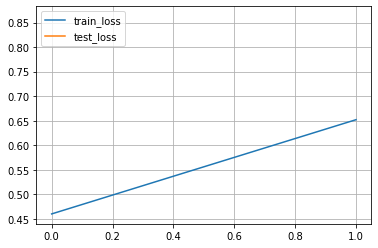

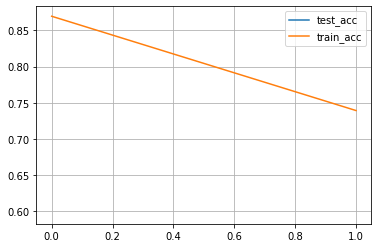

In [29]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
print(metrics.head())

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "test_loss"]].plot(grid=True, legend=True)
df_metrics[["test_acc", "train_acc"]].plot(grid=True, legend=True)